# Generating art using GANs

In [1]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
artists = pd.read_csv("/Users/jtmohan/Downloads/archive/artists.csv")

for i in artists['name']:
    print(i,end=" | ")

Amedeo Modigliani | Vasiliy Kandinskiy | Diego Rivera | Claude Monet | Rene Magritte | Salvador Dali | Edouard Manet | Andrei Rublev | Vincent van Gogh | Gustav Klimt | Hieronymus Bosch | Kazimir Malevich | Mikhail Vrubel | Pablo Picasso | Peter Paul Rubens | Pierre-Auguste Renoir | Francisco Goya | Frida Kahlo | El Greco | Albrecht Dürer | Alfred Sisley | Pieter Bruegel | Marc Chagall | Giotto di Bondone | Sandro Botticelli | Caravaggio | Leonardo da Vinci | Diego Velazquez | Henri Matisse | Jan van Eyck | Edgar Degas | Rembrandt | Titian | Henri de Toulouse-Lautrec | Gustave Courbet | Camille Pissarro | William Turner | Edvard Munch | Paul Cezanne | Eugene Delacroix | Henri Rousseau | Georges Seurat | Paul Klee | Piet Mondrian | Joan Miro | Andy Warhol | Paul Gauguin | Raphael | Michelangelo | Jackson Pollock | 

In [5]:
batch_size=128
image_size=(64,64)
stats=(0.5,0.5,0.5),(0.5,0.5,0.5)

In [7]:
transform_ds=transforms.Compose([transforms.Resize(image_size),transforms.ToTensor(),transforms.Normalize(*stats)])
train_ds=torchvision.datasets.ImageFolder(root="/Users/jtmohan/Downloads/archive/resized",transform=transform_ds)
train_dl=DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
print(len(train_ds))


8683


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])


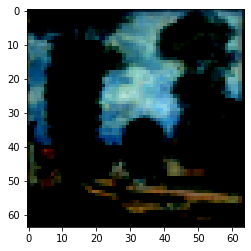

In [8]:
im,_=train_ds[872]
print(im.size())
#permute?
plt.imshow(im.permute(1,2,0))

In [9]:
#work on this..
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [10]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

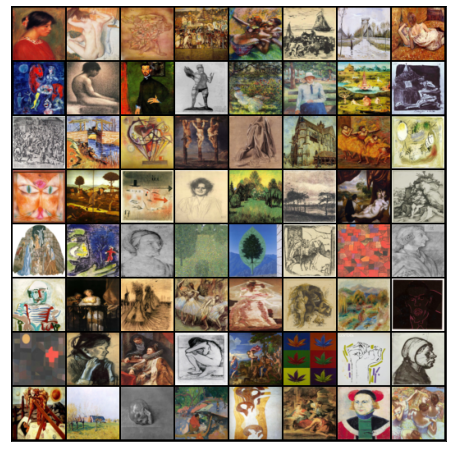

In [11]:
show_batch(train_dl)

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device=get_default_device()
device

device(type='cpu')

In [14]:
train_dl=DeviceDataLoader(train_dl,device)

In [15]:
#Chor Police game essentially
#Generator - thief ; Discriminator-police
#Generator generates realistic fake images
#Discriminator catches the real work
#The discriminator takes two sets of input; real images and fake images. 
#Its job is to classify them properly whether the given image is fake or real.
#use CNNs for dealing with real vs fake images

In [16]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [17]:
discriminator=to_device(discriminator,device)

In [18]:
latent_size=150

In [19]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

# Model Defining

torch.Size([128, 3, 64, 64])


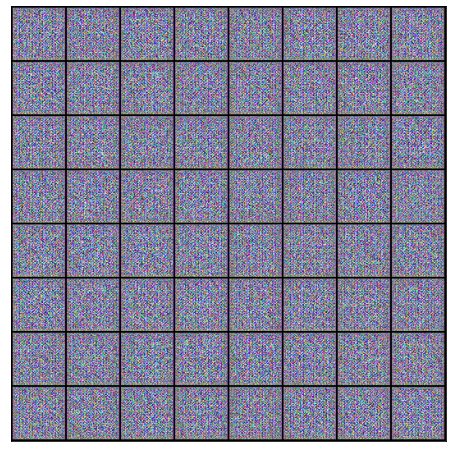

In [20]:
xb=torch.randn(batch_size,latent_size,1,1)
fake_images=generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [21]:
#help(torch.randn)

In [22]:
generator=to_device(generator,device)

In [23]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [24]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [25]:
from torchvision.utils import save_image

In [26]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [27]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [28]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


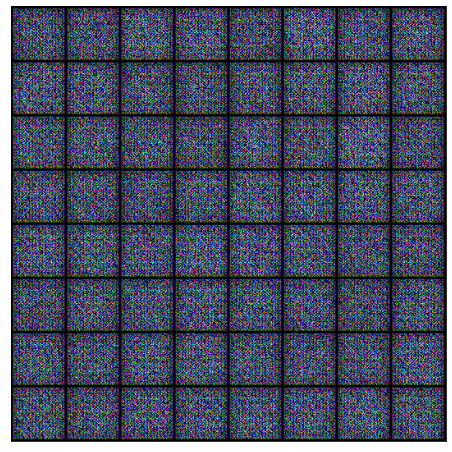

In [29]:
save_samples(0, fixed_latent)

In [30]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [31]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [32]:
from IPython.display import Image 

In [41]:
lr = 0.002
epochs = 5


In [36]:
history = fit(epochs,lr,1)

  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [1/1], loss_g: 4.5285, loss_d: 0.5335, real_score: 0.8890, fake_score: 0.3162
Saving generated-images-0013.png


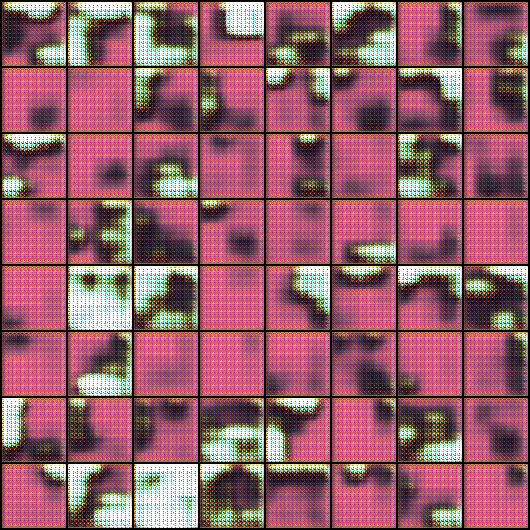

In [39]:
Image('generated/generated-images-0013.png')


In [40]:
import pickle
Pkl_Filename = "../generate_art_gans.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(history, file)
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Pickled_Model = pickle.load(file)

Pickled_Model



([4.528540134429932],
 [0.5334826111793518],
 [0.8890171051025391],
 [0.3161575198173523])